<a href="https://colab.research.google.com/github/amit-timalsina/Correct-image-alignment/blob/master/Correct_image_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (19.5 MB/s)
debconf: unable to initia

In [ ]:
import os

PROJECT_ROOT_DIR = "."
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
FIMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, 'final_images')
os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(FIMAGE_PATH, exist_ok=True)

In [ ]:
image_files = [os.path.join(IMAGE_PATH, image) for image in os.listdir(IMAGE_PATH)]
image_files

['./images/10.jpg',
 './images/41.png',
 './images/6 2.jpg',
 './images/AWT009.jpg',
 './images/billing-invoice-for-legal-services.jpg',
 './images/0f97914844b786b0d2ef21339286cdf6 - 2.jpg',
 './images/5f228310d55c683ed29aa8c0adda7efc.jpg',
 './images/7.jpg',
 './images/5.jpg',
 './images/6.jpg',
 './images/law-firm-invoice-template.jpg',
 './images/0e27f636242845138158f132878a3351.jpg',
 './images/4.jpg']

In [ ]:
import cv2
import numpy as np

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, M=rot_mat, dsize=image.shape[1::-1], 
                          flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue = [255, 255, 255])
  return result

In [ ]:
#imports
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.ndimage import interpolation as inter
from google.colab import files
from PIL import Image as im

"""
  For correcting the angle of image
"""
def correct_alignment(img_dir = None):
  if img_dir:
    IMG_DIR = img_dir
  else:
    uploaded = files.upload()
    IMG_DIR = list(uploaded.keys())[0]
  image = cv2.imread(IMG_DIR)

  # Using "Projection profile" method for skew 

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # Converting image into binary image, any arrray element <= 210 converted to 0
  ret, bin_img = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

  # To compute the score of the image when rotated at an angle 
  # which is the squared difference between the peaks.
  # Peaks --> The sum of the pixels along the rows of the image matrix(histogram of pixels)
  def find_score(arr, angle):
      data = inter.rotate(arr, angle, reshape=False, order=0)
      hist = np.sum(data, axis=1)
      score = np.sum((hist[1:] - hist[:-1]) ** 2)
      return score

  # Set delta as per the precise alignment you require. But it will require more time to compute
  delta = 1
  limit = 4
  # Angles at which binary image will be rotated
  angles = np.arange(-limit, limit+delta, delta)
  scores = []

  for angle in angles:
      score = find_score(bin_img, angle)
      scores.append(score)

  # The angle at which maximum difference between peaks(score) is found is the
  # skew angle
  best_score = max(scores)
  best_angle = angles[scores.index(best_score)]
  print('Best angle to rotate: ', best_angle)

  # rotate the image to deskew it
  if np.abs(best_angle)>0:
    print('Rotating the image')
    rotated = rotate_image(image, float(best_angle))
  else:
    rotated = image
  # OpenCV use BGR method to convert image into array but PIL use RGB method
  # So, converting BGR to RGB to store image using PIL.Image
  b, g, r = cv2.split(rotated)
  rotated2 = cv2.merge([r, g, b])
  img = im.fromarray(rotated2)
  img.save('angle-corrected_' + IMG_DIR.split('/')[-1])
  return IMG_DIR

In [ ]:
#imports
import pytesseract
import urllib
import re
import imutils #added

"""
  For correcting orientation of image
"""

def correct_orientation(img_dir=None):
  if img_dir:
    correct_alignment(img_dir)
    IMG_DIR = img_dir
  else:
    IMG_DIR = correct_alignment()
  image = cv2.imread('angle-corrected_' + IMG_DIR.split('/')[-1])
  # One of the provided image gives Tesseract error. So, using try except block.
  try:
    rot_data = pytesseract.image_to_osd(image);
    rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)
    angle = float(rot)
    print("Rotation Angle for orientation: {}".format(angle))

  except Exception as e:
    print(e)
    print("Skipping orientation correction")
    angle = 0.0

  # pytesseract.image_to_osd detects the image orientation in degrees as 270
  # for both 90 and 270 degree rotated images
  # So, first rotating the image by 90. So, 90 degree rotated image becomes inverted(180) and
  # 270 degree rotated image becomes straight(0). Then using image_to_osd to again detect image
  # orientation and rotate to correct it accordingly.
  if angle == 90.0:
    image = imutils.rotate_bound(image, angle)
    rot_data = pytesseract.image_to_osd(image);
    rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)
    angle = float(rot)
    print("Rotation Angle for orientation(2): {}".format(angle))

  # rotate the image to correct orientation
  img_rotated = imutils.rotate_bound(image, angle)#added
  cv2_imshow(img_rotated)
  b, g, r = cv2.split(img_rotated)
  rotated2 = cv2.merge([r, g, b])

  img = im.fromarray(rotated2)
  filename = os.path.join(FIMAGE_PATH, IMG_DIR.split('/')[-1])
  img.save(filename)
  print('Final image saved in {}'.format(filename) )
  return None

Best angle to rotate:  -2
Rotating the image
Rotation Angle for orientation: 0.0


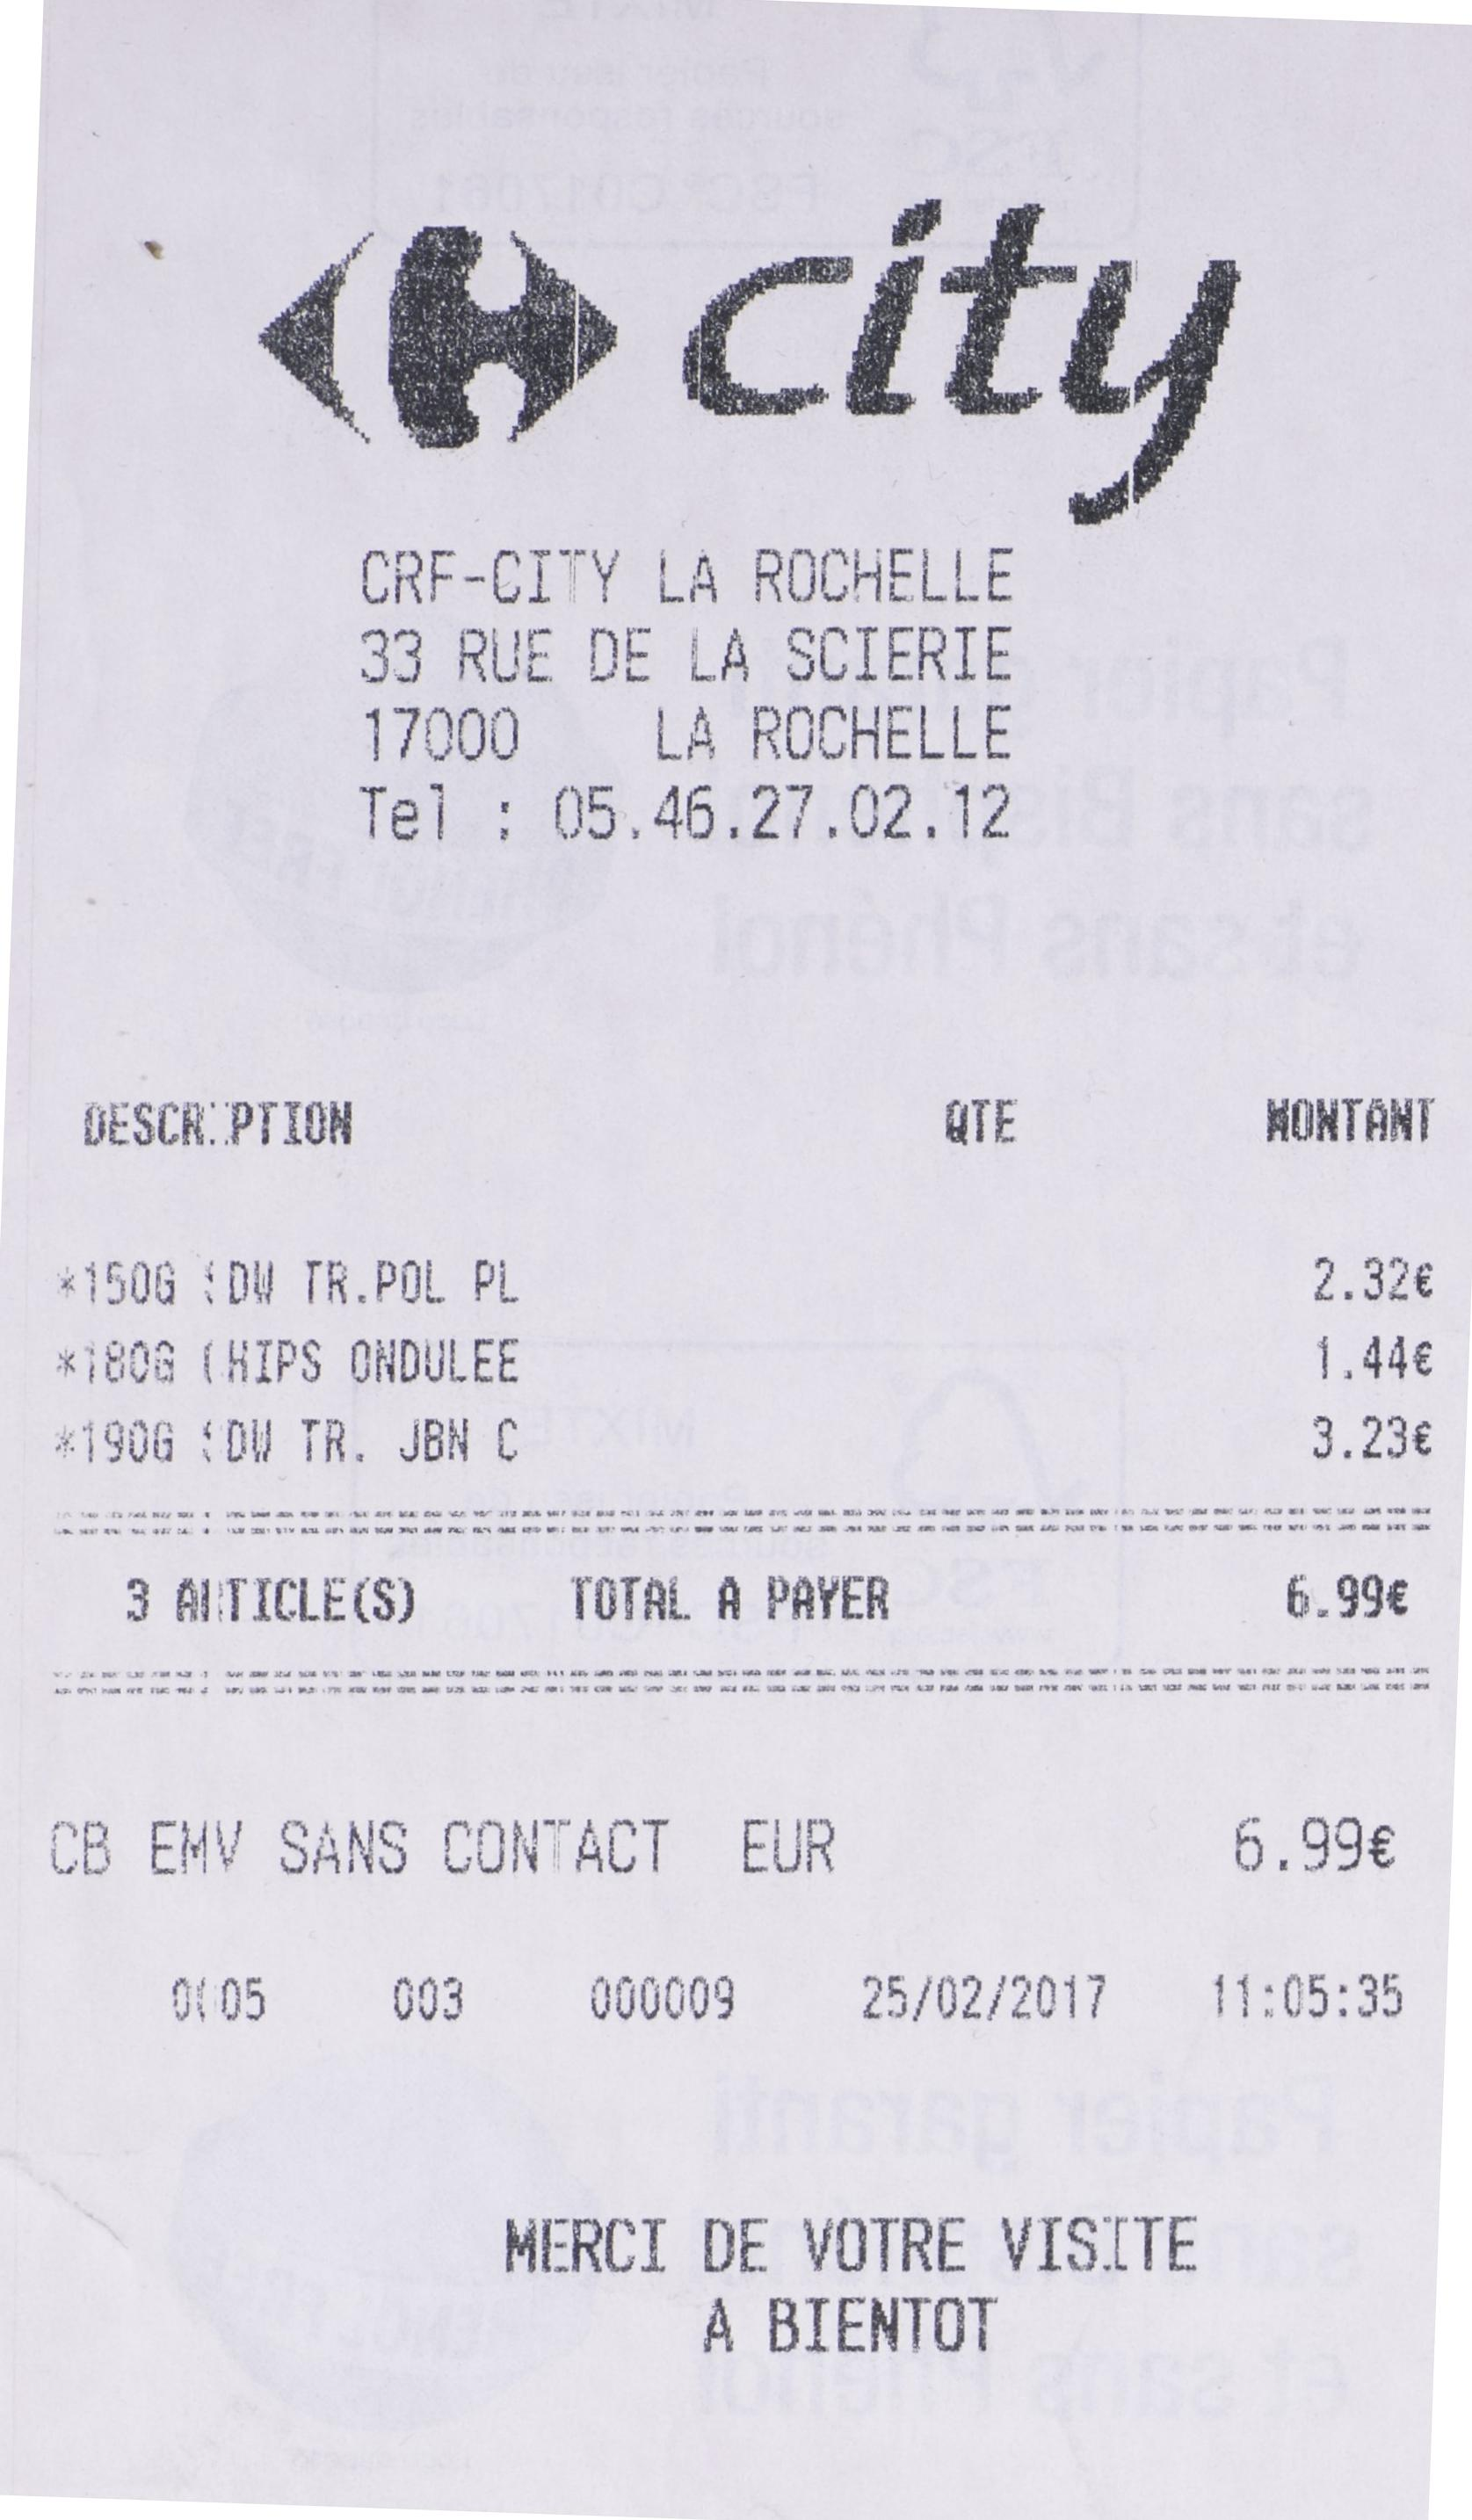

Final image saved in ./final_images/6 2.jpg


In [ ]:
correct_orientation(receipt_files[2])